In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import torch
from tqdm import tqdm
from src.models import SpaceNet
from src.utils import spatial_correlation, ratemap_collage

plt.style.use("figures/project_style.mplstyle")

In [2]:
def permutation_matrix(n):
    Q = np.eye(n)
    Q = np.array([Q[i] for i in np.random.choice(n, replace = False, size = n)])
    return torch.tensor(Q.astype("float32"))

def random_continuous_rotation_matrix(theta, n, A = None):
    if A is None:
        A = np.random.uniform(0, 1, (n,n))
    S = 0.5*(A - A.T) # S - S.T 

    Q = scipy.linalg.expm(theta*S)
    return torch.tensor(Q.astype("float32"))

def random_rotation(n):
    Q = torch.tensor(scipy.stats.special_ortho_group(n).rvs(1).astype("float32"))
    return Q

def reflection(n):
    Q = torch.tensor(scipy.stats.special_ortho_group(n).rvs(1).astype("float32"))
    a = torch.clone(Q[:,0])  # interchanging columns switches sign of determinant
    b = torch.clone(Q[:,1])
    Q[:,0] = b
    Q[:,1] = a
    return Q


In [3]:
model = torch.load("models/256_ff_05scale_0.pt")
# model  = torch.load("models/256_ff_01scale_6.pt")
# model  = torch.load("models/256_ff_0.pt")
model.lam, model.scale, model.beta

/var/folders/rv/mky69fln76nbwl7qkb06318h0000gn/T/ipykernel_6755/888517608.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model  = torch.load("models/256_ff_05scale_0.pt

(0.1, 0.5, 0.5)

In [4]:
# evaluate on 2x2 grid
n = 32
x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x,y)
u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis = -1), dtype= torch.float32)

In [5]:
_,p = model(u)
p = p.T.detach().numpy().reshape(-1,n,n)

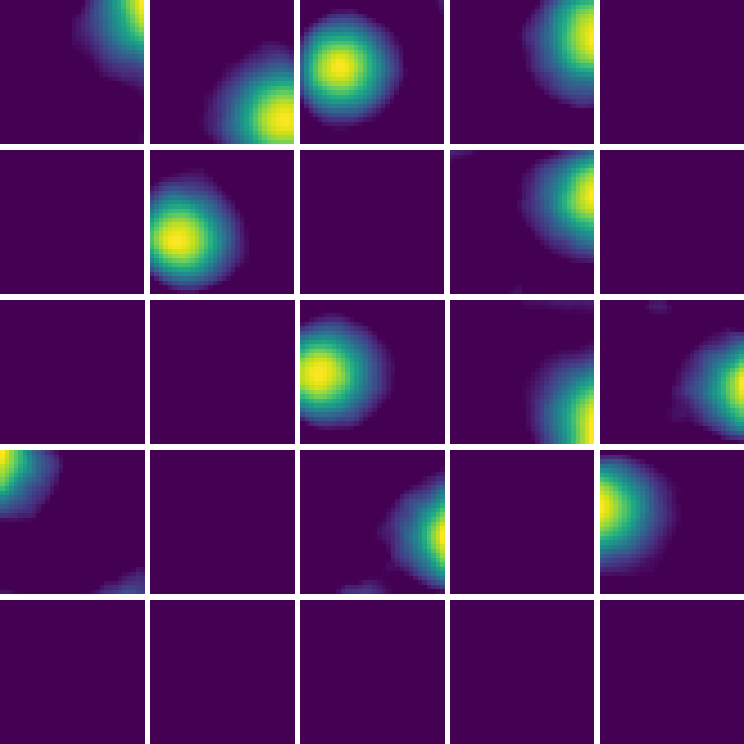

In [6]:
ratemap_collage(p[:25]);

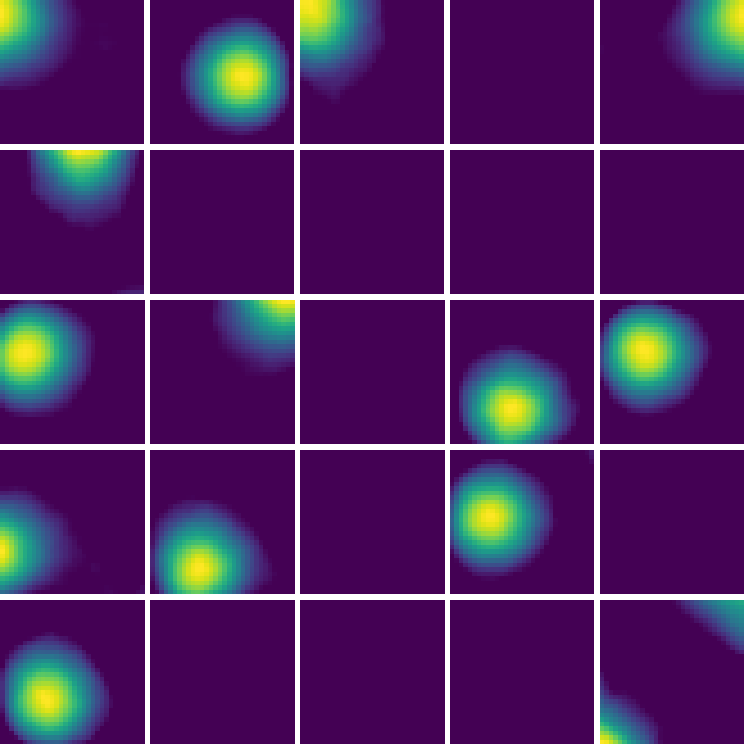

In [7]:
p_permute = np.tensordot(permutation_matrix(len(p)), p, axes = ((-1, 0)))
ratemap_collage(p_permute[:25]);

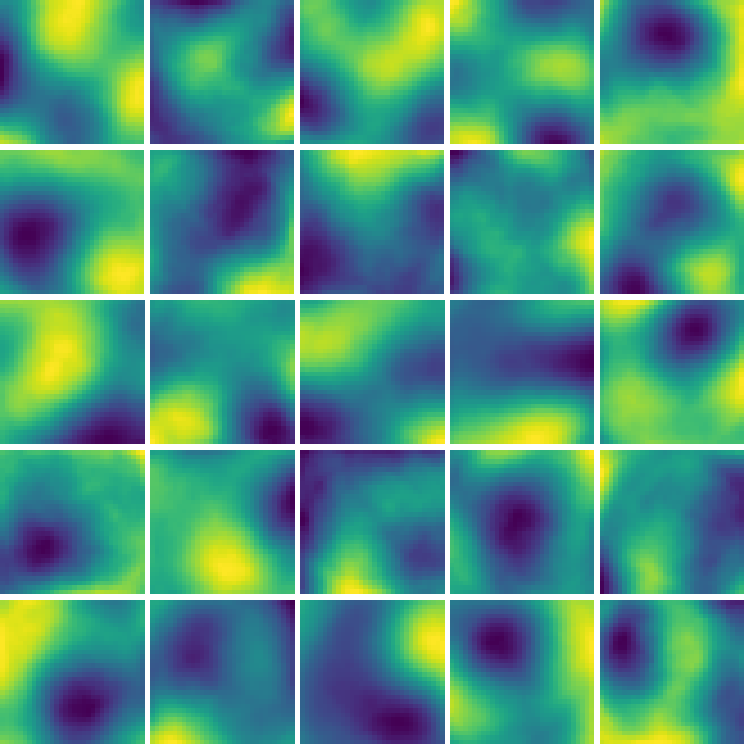

In [8]:
p_rotate = np.tensordot(random_rotation(len(p)), p, axes = (-1, 0))
ratemap_collage(p_rotate[:25]);

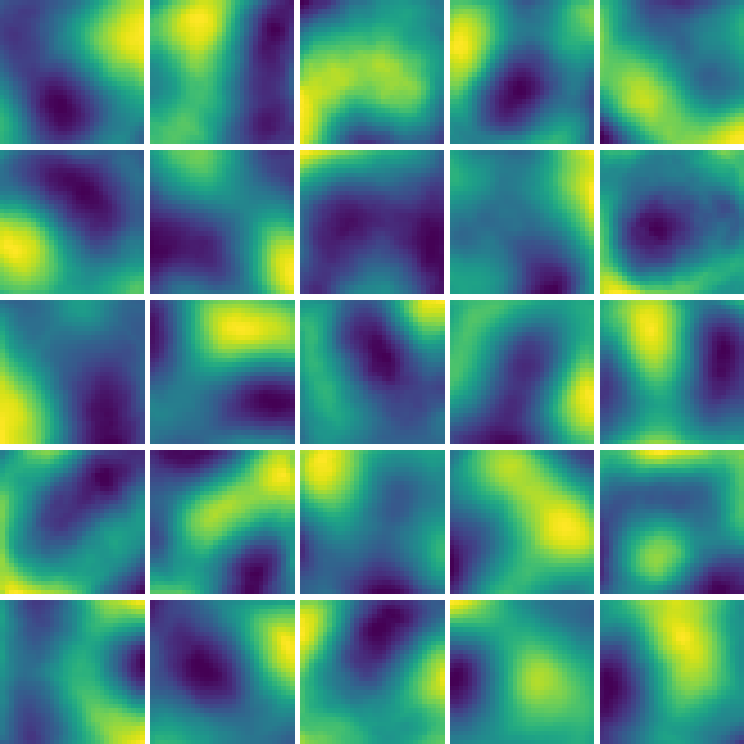

In [9]:
p_reflect = np.tensordot(random_rotation(len(p)), p, axes = (-1, 0))
ratemap_collage(p_reflect[:25]);

Text(0, 0.5, 'Count')

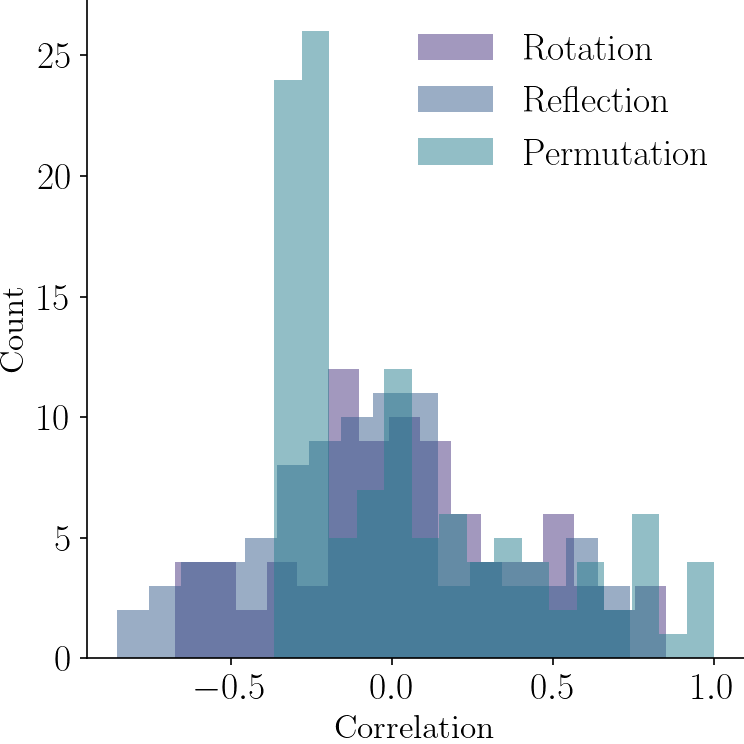

In [10]:
rotation_corr = spatial_correlation(p, p_rotate)
permutation_corr = spatial_correlation(p, p_permute)
reflection_corr = spatial_correlation(p, p_reflect)

plt.figure(figsize = (5,5))
plt.hist(rotation_corr, bins = 16, label  = "Rotation", alpha = 0.5)
plt.hist(reflection_corr, bins = 16, label = "Reflection", alpha = 0.5)
plt.hist(permutation_corr, bins = 16, label  = "Permutation", alpha = 0.5)
plt.legend(frameon = False)
plt.xlabel("Correlation")
plt.ylabel("Count")

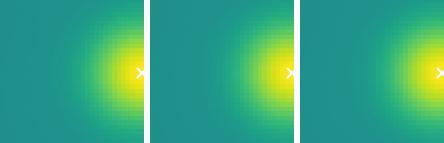

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (3, 1))

a = 31
b = 16

for i, pi in enumerate([p_rotate, p_reflect, p_permute]):
    dp = np.linalg.norm(pi - pi[:,b,a,None,None],axis=-0)
    si = np.exp(-dp**2)
    ax[i].imshow(si, vmin = 0, vmax = 1)
    ax[i].axis("off")
    ax[i].plot(a,b, "wx", markersize = 5)

In [40]:
n_extend = 10*n
dx = torch.tensor(2/n) # bin size in coordinates

In [52]:
q0 = permutation_matrix(len(p))
# q0 = random_rotation(len(p))#torch.tensor(np.random.uniform(0, 1, (len(p), len(p))).astype("float32"))
# q0 = torch.tensor(np.random.uniform(-1, 1, (len(p), len(p))).astype("float32"))

S = 0.5*(q0 - q0.T) # S - S.T = 0

V = torch.linalg.matrix_power(S, 2)

p_prime = torch.zeros((p.shape[0], p.shape[1], n_extend + n))
p_prime[:,:n, :n] = torch.tensor(p)

sim = (1 - model.beta)*torch.exp(-dx**2/(2*model.scale**2)) + model.beta

for i in range(n_extend):
    z = p_prime[:,:, i + n-1]
    denom = torch.sum(z*(V@z), dim = 0)
    factor = torch.sqrt(torch.log(sim)/denom)
    factor = torch.mean(factor) 
    q = random_continuous_rotation_matrix(factor, len(p), q0)
    p_prime[:,:,i+n] = q@z

relu = lambda x: np.maximum(0, x)
p_prime = relu(p_prime.detach().numpy())
p_prime = np.transpose(p_prime, (0, -1, -2))

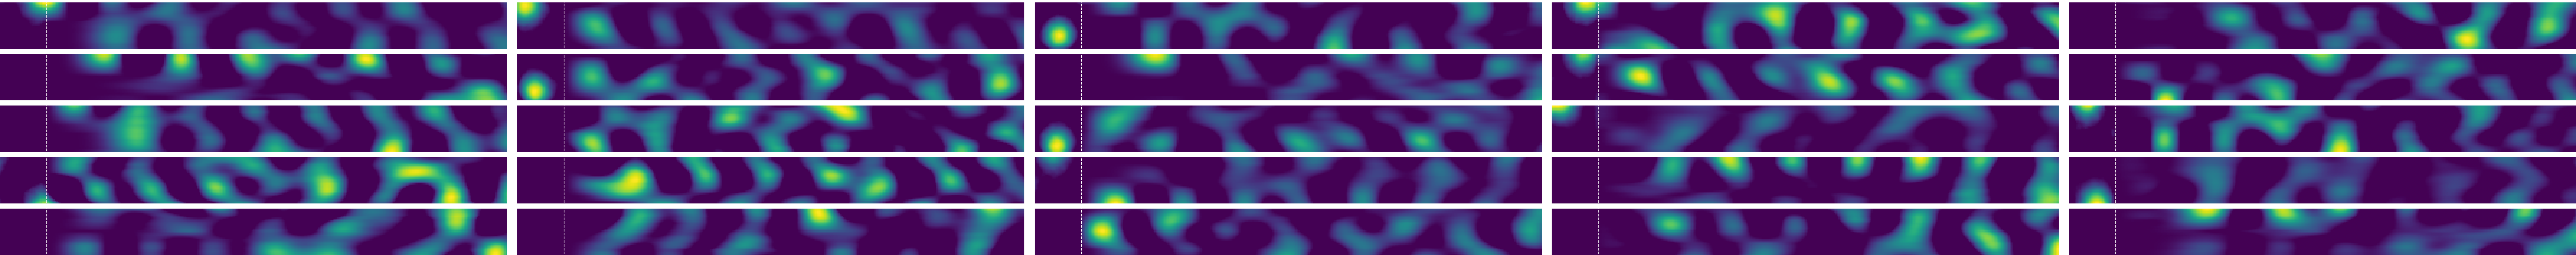

In [53]:
fig, axs = ratemap_collage(p_prime[:25],5,  figsize = (50, 5))
[axs[i,j].vlines(32, 0, 32, "w", linestyles = "--") for i in range(5) for j in range(5)];

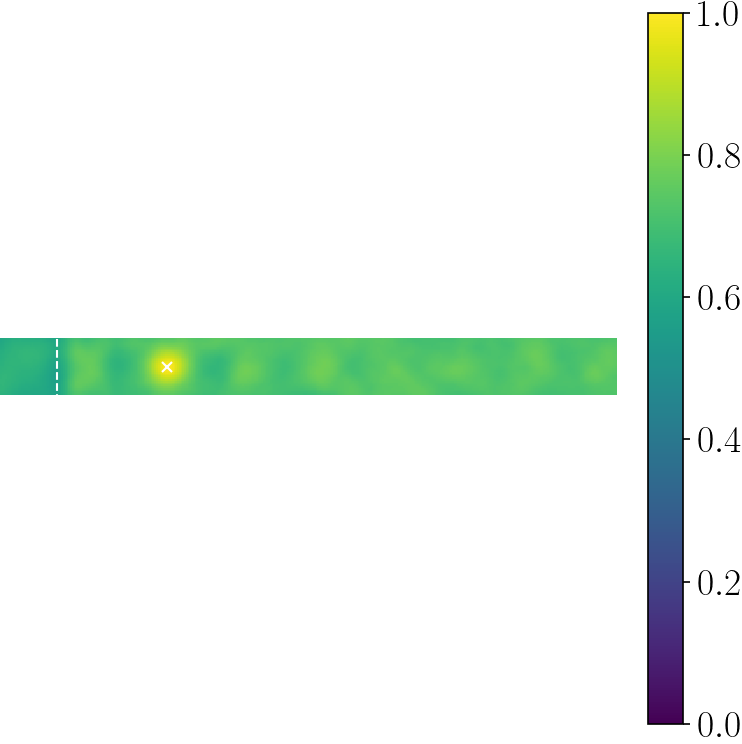

In [54]:
plt.figure(figsize = (5,5))
a = 16 
b = 31 + 32*2
dp = np.linalg.norm(p_prime - p_prime[:,b,a,None,None],axis=-0)
si = np.exp(-dp**2)
plt.imshow(si.T, vmin = 0)
plt.axis("off")
plt.plot(b,a, "wx", markersize = 5)
plt.vlines(32, 0, 32, "w", linestyles = "dashed")
plt.colorbar()